# COMP90051 Workshop 4
## Logistic regression and gradient based training
***

In this workshop we'll be implementing logistic regression from scratch, using various techniques for gradient descent, namely batch gradient descent, stochastic gradient descent and BFGS, a quasi Newton method.

First we'll import the relevant lirbaries.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 108
RND_SEED = 123456789

### 1. Binary classification data
Let's begin by generating some binary classification data.
To make it easy for us to visualise the results, we'll stick to a two-dimensional feature space.

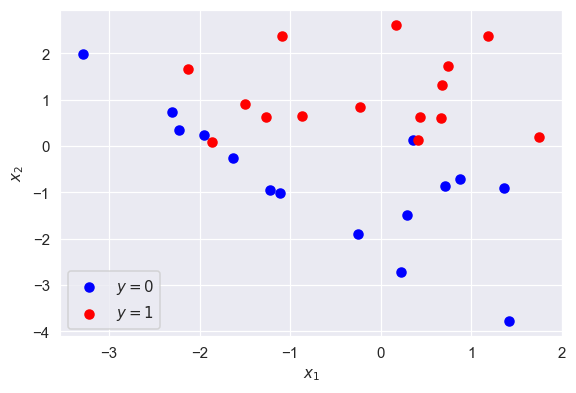

In [15]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = 30, n_features = 2, n_informative=2, n_redundant=0, random_state=RND_SEED)
X_b = np.column_stack((np.ones_like(y), X)) 
# add on a column of 1s, so that each instance includes a constant feature; accordingly the first weight is the bias term

plt.scatter(X[y==0,0], X[y==0,1], color='b', label="$y = 0$")
plt.scatter(X[y==1,0], X[y==1,1], color='r', label="$y = 1$")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

***
**Question:** What do you notice about the data? It is possible for logistic regression to achieve perfect accuracy on this data?
***

## 2. Logistic Regression
In binary classification we receive training data $\mathcal{D} = \left((\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\right)$, where $\mathbf{x}_k \in \mathbb{R}^m$ denotes the feature vector associated with the $k$th training point and the targets $y \in \{0,1\}$. Logistic regression models the distribution of the binary target $y$ *conditional* on the feature vector $\mathbf{x}$ as

\begin{equation}
y | \mathbf{x} \sim \mathrm{Bernoulli}[\sigma(\mathbf{w}^T \mathbf{x})]
\end{equation}

where $\mathbf{w} \in \mathbb{R}^N$ is the weight vector (with bias term included) and $\sigma(z) = 1/(1 + e^{-z})$ is the logistic function. Note here our object of interest is the conditional probability of a particular instance belonging to class 1 given observation of the associated feature vector $\mathbf{x}$:

$$p(y = 1 \vert \mathbf{x}) = \sigma\left(\mathbf{w}^T \mathbf{x}\right) $$
 
To find appropriate parameters $\mathbf{w}$, we want to maximize the log-likelihood with respect to $\mathbf{w}$, in lecture it was shown this is equivalent to minimization of the sum of cross-entropies over the instances ($i = 1,\ldots,n$) in the training set

$$
\mathcal{L}_{CE}(\mathbf{v}; \mathbf{x}, \mathbf{y}) = -\log \prod_{i=1}^n p\left(y_i \vert \mathbf{x}_i\right) = - \sum_{i = 1}^{n} \left\{ y_i \log p(y=1 \vert \mathbf{x}_i) + (1 - y_i) \log p (y=0 \vert \mathbf{x}_i) \right\}
$$

This quantity is also referred to as the *empirical risk*.

***
#### **Exercise:**
Given we model the conditional probability of label $y=1$ to be $p(y = 1 \vert \mathbf{x}) = \sigma\left(\mathbf{w}^T \mathbf{x}\right)$, show that prediction is based on a linear decision rule given by the sign of logarithm of the ratio of probabilities:

\begin{equation}
    \log \frac{p(y=1 \vert \mathbf{x})}{p(y=0 \vert \mathbf{x})} = \mathbf{w}^T \mathbf{x}
\end{equation}

This is why logistic regression is referred to as a _log-linear model_. What is the decision boundary for logistic regression? 
***

We're going to find a solution to this minimisation problem using gradient descent.

Let's start by writing a function to compute the empirical risk, also known as the cross entropy loss, $\mathcal{L}_{CE}$. We'll need to evaluate the risk later on to generate convergence plots, so we define a function for this below.

In [23]:
from scipy.special import expit # this is the logistic function
sigmoid = expit

def risk(w, X, y):
    """Evaluate the empirical risk under the cross-entropy (logistic) loss
    
    Parameters
    ----------
    X : array of shape (n_samples, n_features)
        Feature matrix. The matrix must contain a constant column to 
        incorporate a non-zero bias.
        
    y : array of shape (n_samples,)
        Response relative to X. Binary classes must be encoded as 0 and 1.
    
    w : array of shape (n_features,)
        Weight vector.
    
    Returns
    -------
    risk : float
    """
    prob_1 = sigmoid(X @ w) 
    cross_entropy = -(y @ np.log(prob_1) + ((1 - y) @ np.log(1 - prob_1))) # fill in
    return cross_entropy

We'll also need to be able to compute the _gradient_ of the empirical risk, in order to implement gradient descent. We will use the following result (if you're familiar with vector calculus, you may wish to derive this yourself):
$$
\nabla_{\mathbf{w}} \mathcal{L}_{CE}(\mathbf{w}) =  \sum_{i = 1}^{n} \left(\sigma(\mathbf{w}^T \mathbf{x}_i) - y_i \right)\mathbf{x}_i
$$

The function below implements the above gradient.

***
**Exercise:** Complete the `grad_risk` function below, which computes $\nabla_{\mathbf{w}} \mathcal{L}_{CE}(\mathbf{w})$ for a given weight vector $\mathbf{w}$ and training data $\mathbf{X}$ and $\mathbf{y}$.
***

In [20]:
def grad_risk(w, X, y):
    """
    Evaluate the gradient of the empirical risk
    
    Parameters
    ----------
    X : array of shape (n_samples, n_features)
        Feature matrix. The matrix must contain a constant column to 
        incorporate a non-zero bias.
        
    y : array of shape (n_samples,)
        Response relative to X. Binary classes must be encoded as 0 and 1.
    
    w : array of shape (n_features,)
        Weight vector.
    
    Returns
    -------
    grad_w : array of shape (n_features,)
    """
    # fill in 
    mu = sigmoid(X @ w) 
    grad_w = (mu - y) @ X
    return grad_w

# Test case
if RND_SEED == 0:
    test_grad_risk_actual = grad_risk(X_b, y, np.ones(3))
    test_grad_risk_desired = np.array([0.11641865, -0.25260051, 0.20606407])
    np.testing.assert_allclose(test_grad_risk_actual, test_grad_risk_desired)

## 3. Gradient descent

Here we'll write a function to compute the solution through vanilla gradient descent. Recall that we follow the negative of the gradient in parameter space to update our parameters. Recall the basic update loop is as follows:

$$ \bf{w}^{(t+1)} = \bf{w}^{(t)} - \eta_t \nabla_w \mathcal{L}(\bf{w}) $$

Note that this simple procedure is the workhorse of many non-convex optimization programs, such as those used in modern neural network libraries. Contemporary libraries add more spice to the exact update, but the core idea of traversing some loss landscape in the direction of the negative gradient remains the same.

Typically we halt when some stopping condition is reached, in this case we'll stop when the 2-norm of the difference between iterates drops below some threshold $\epsilon$.

$$ \Vert \bf{w}^{(t+1)} - \bf{w}_{(t)} \Vert^2 \leq \epsilon $$

You could also use other stopping criteria, such as if the difference between two consecutive loss values drops below some threshold.

***
**Exercise:** Complete the `fit_logistic_GD` function below, which performs iterative gradient descent training.
***

In [21]:
def fit_logistic_GD(X, y, w0, eta=0.01, iterations=100, tol=1e-5):
    """Performs iterative training using Gradient Descent
    
    Parameters
    ----------
    X : array of shape (n_samples, n_features)
        Feature matrix. The matrix must contain a constant column to 
        incorporate a non-zero bias.
    
    y : array of shape (n_samples,)
        Response relative to X. Binary classes must be encoded as 0 and 1.
    
    w0 : array of shape (n_features,)
        Current estimate of the weight vector.

    eta : float
        Learning rate, here a constant (but see notes below)
    
    max_iter : int
        Maximum number of GD iterations 
    
    tol : float
        Stop when the 2-norm of the gradient falls below this value.

    Returns
    -------
    w : list of arrays of shape (n_features,)
        History of weight vectors.
    """    
    w_history = [w0]
    w = w0

    for itr in range(iterations):
        
        grad_w = grad_risk(w, X, y) 
        w = w - eta * grad_w  # fill in
        w_history.append(w)
        
        # Stopping condition
        if np.linalg.norm(grad_w) <= tol:
            break
        
    print("Stopping after {} iterations".format(itr+1))
    print("2-norm of grad is {:.4g}".format(np.linalg.norm(grad_w)))
    print("Risk is {:.4g}".format(risk(w, X, y)))

    return w_history

Let's run the algorithm on the 2D classification data we generated in Section 1 and visualise the result. Does the result look reasonable? Try adjusting the learning rate and seeing what effect this has on convergence. You may want to evaluate the contour plot below which provides a visualisation of the learning steps.

*Note: we've chosen an arbitrary starting point for the weights, `w0`.*

Stopping after 100 iterations
2-norm of grad is 0.000758
Risk is 8.999


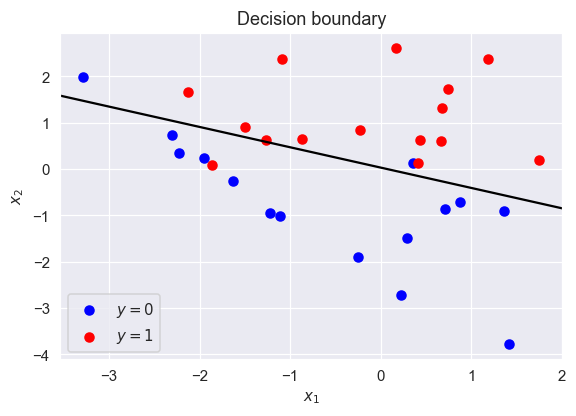

In [24]:
w_history_gd = fit_logistic_GD(X_b, y, w0=(1,4,2), eta=0.1)

def plot_decision_boundary(X, y, w):
    """Plots the decision boundary of a logistic regression classifier defined 
    by weights `w`
    """
    fig, ax = plt.subplots()
    ax.scatter(X_b[y==0,1], X_b[y==0,2], color='b', label="$y = 0$")
    ax.scatter(X_b[y==1,1], X_b[y==1,2], color='r', label="$y = 1$")
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.plot(list(xlim), [-w[0]/w[2] - w[1]/w[2] * x for x in xlim], ls = "-", color="k")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title("Decision boundary")
    ax.legend()
    plt.show()

plot_decision_boundary(X_b, y, w_history_gd[-1])

***
**Question:** Is the solution what you expected? Is it a good fit for the data?
***

We can also check the validity of our implementation by comparing with scikit-learn's implementation. Note that the scikit-learn implementation incorporates $L_2$ regularisation by default, so we need to switch it off by setting `penalty = 'none'`.

In [25]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='none')
clf.fit(X, y)
w_sklearn = np.r_[clf.intercept_, clf.coef_.squeeze()]
print("Weights according to GD: {}".format(w_history_gd[-1]))
print("Weights according to scikit-learn: {}".format(w_sklearn))

Weights according to GD: [-0.08539173  1.28453747  2.92800381]
Weights according to scikit-learn: [-0.08534939  1.28411908  2.92708799]


Let's take a look at the path taken by the GD algorithm to reach the optimal solution.
We plot the weight vectors at each iteration $\mathbf{w}_0, \mathbf{w}_1, \ldots$ on top of contours of the empirical risk $\mathcal{L}_{CE}(\mathbf{w})$. 
The darker the shade, the lower the empirical risk. Note that we fix the bias term at its trained value, such that we can plot the objective surface in 2D.

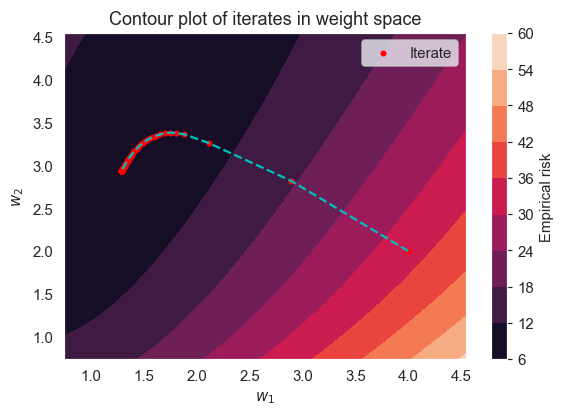

In [26]:
def plot_iterates(X, y, w_history):
    """Plots the path of iterates in weight space (excluding the bias)"""
    w_history = np.array(w_history)
    
    # Compute axes limits
    w12_max = w_history[:,1:].max()
    w12_min = w_history[:,1:].min()
    w12_ran = w12_max - w12_min
    border = 0.2
    
    # Compute objective on grid
    w12 = np.linspace(w12_min - border * w12_ran, w12_max + border * w12_ran, num=100)
    w1v, w2v = np.meshgrid(w12, w12)
    w12v = np.c_[w1v.ravel(), w2v.ravel()]
    z = np.array([risk(np.r_[w_history[-1][0], w12], X_b, y) for w12 in w12v])
    z = z.reshape(w1v.shape)

    plt.contourf(w1v, w2v, z)
    plt.colorbar(label='Empirical risk')
    plt.plot(w_history[:,1], w_history[:,2], c='c', ls='--')
    plt.scatter(w_history[:,1], w_history[:,2], c='r', marker='.', label='Iterate')
    plt.xlabel('$w_1$')
    plt.ylabel('$w_2$')
    plt.legend()
    plt.title('Contour plot of iterates in weight space')
    plt.show()

plot_iterates(X_b, y, w_history_gd)

## 4. Logistic regression via BFGS

Next, let's compare the GD algorithm with a more advanced second-order method of gradient descent.

Gradient descent only uses first order derivative information to update parameters (it extrapolates from the current parameter value using a linear approximation to the function). Second-order methods such as [BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) can use the second-order derivative information to increase the rate of convergence. BFGS constructs an approximation to the Hessian matrix of second derivatives at each iteration, and uses this information to guide the next update. However such methods leveraging Hessian information tend to require a high space complexity and are only used for problems with a relatively low number of parameters.

Now that we've implemented functions to compute the objective and the gradient, we can plug them into `fmin_bfgs`.

In [27]:
from scipy.optimize import fmin_bfgs

def fit_logistic_BFGS(X, y, w0):
    w_history = [w0]
    def display(w):
        # Function for displaying progress
        grad = grad_risk(w, X, y)
        w_history.append(w)
    
    w = fmin_bfgs(f=risk, fprime=grad_risk, 
                  x0=w0, args=(X, y), disp=True, 
                  callback=display)
    return w_history

Let's try it out!

Optimization terminated successfully.
         Current function value: 8.998946
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11


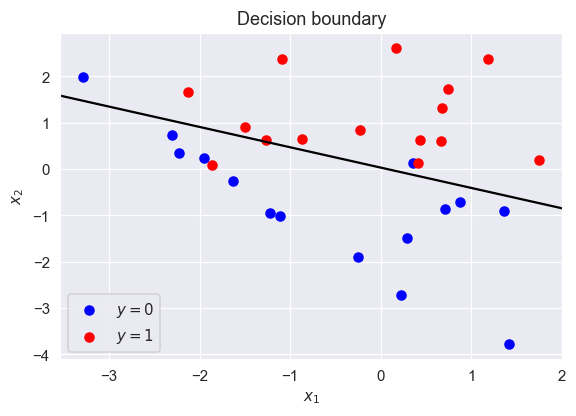

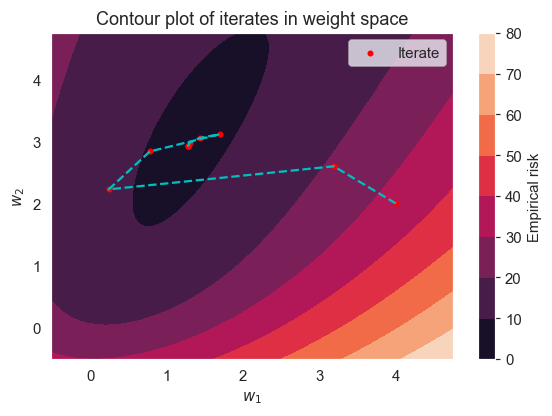

In [28]:
w_history_bfgs = fit_logistic_BFGS(X_b, y, w0=(1,4,2))
plot_decision_boundary(X_b, y, w_history_bfgs[-1])
plot_iterates(X_b, y, w_history_bfgs)

Let's now measure the accuracy of our trained model. To do so, we will first compute the predictions of the model. 

***
**Exercise:** Complete the `get_predictions` function below which implements the decision function for logisitic regression, i.e., given inputs $\mathbf{X}$ and parameters $\mathbf{w}$, return a vector of classification labels for each instance. To do so, you will need to compute the $P(y=1|\mathbf{x})$ for each instance, and threshold at 0.5. 

*Hint: you may want to use `np.where` to implement the threshold function.*
***

In [32]:
from sklearn.metrics import accuracy_score

def get_predictions(w, X):
    #  Implement the logistic regression prediction rule here
    """
    Inputs:
    w:       Weights, shape [m]
    X:       Testing data, shape [N, m]
    
    Outputs:
    y_pred:  Vector of predictions for given test instances
    """
    # fill in
    y_pred = np.where(sigmoid(X @ w) > 0.5, 1, 0)
    return y_pred

y_pred = get_predictions(w_history_bfgs[-1], X_b)
print('Accuracy achieved: {:.3f}'.format(accuracy_score(y, y_pred)))

Accuracy achieved: 0.900


***
**Question:** What mistake was made above in this method of evaluating the predictive accuracy? Would you expect this result to generalise?
***

## 5. Solving the minimization problem using SGD

The above gradient optimisers have been *batch-based*, that is, they require the objective to be calculated in full, considering all the training points, and its corresponding gradient. For very large datasets and complex models, such as those used in deep learning, it can be desirable to use simpler methods which make more frequent updates and use few data points at each step. *Stochastic gradient descent (SGD)* is the simplest method for doing so, which uses only a single data point in estimating the gradient which is then used to make a gradient update.


***
**Exercise:** Complete the implementation of `fit_logistic_SGD` function below, which implements stochastic gradient descent, with batch size of 1. You can cut and paste from `fit_logisitic_GD` as a starting point.
***
Your job is to implement SGD. We won't worry about a sophisticated convergence test, as this is a bit more involved to design than before when we have exact gradients.

In [56]:
def fit_logistic_SGD(X, y, w0, eta=0.01, iterations=100):
    w_history = [w0]
    w = w0

    for itr in range(iterations):
        # fill in
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        for idx in indices:
            grad_w = grad_risk(w, X[idx:idx+1, :], y[idx:idx+1])
            w = w - eta * grad_w
            w_history.append(w)
        
    return w_history

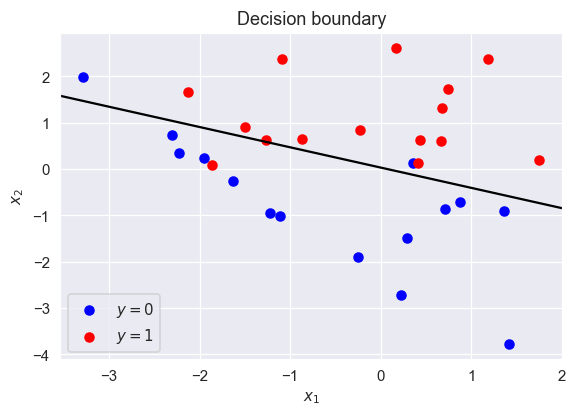

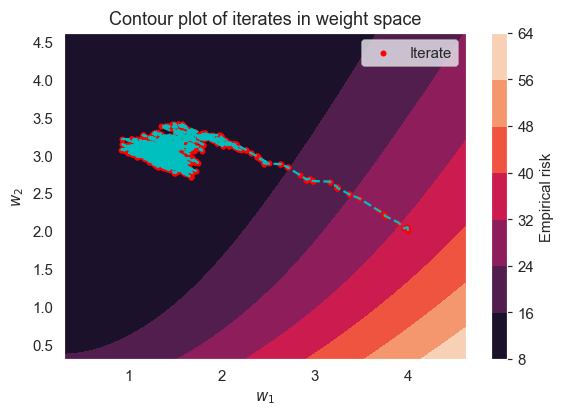

In [57]:
w_history_sgd = fit_logistic_SGD(X_b, y, w0=np.array((1,4,2)), eta=0.1)
plot_decision_boundary(X_b, y, w_history_sgd[-1])
plot_iterates(X_b, y, w_history_sgd)

Clearly this isn't working perfectly, and after initial good progress the weights are bouncing around. This is due to the weight updates being too large. Experiment with a different learning rate, $\eta$, to try and correct this behaviour. Set too low and it will not be too slow, and be terminated before getting near to the optimal parameters. Feel free to try a learning rate schedule where $\eta$ changes with iteration, as suggested above.

***
**Question:** Is SGD a good fit to the problem of training a logistic regression model? Is it as efficient as the above methods?


***
## Bonus: Linearly separable case (optional)


**Exercise:** What happens when you re-run the notebook with `RND_SEED = 90051`?

**Exercise:** Implement a L2 regularisation risk to the objective. This means changing the `risk` and `grad_risk` functions to use the regularised risk function, $\mathcal{L}_{CE} + \lambda \mathbf{w}'\mathbf{w}$, and its corresponding gradient, namely adding $\lambda \mathbf{w}$. Lambda is a hyperparameter which controls the extent of regularisation, and you might want to try out a few values to see its effect, e.g., 0.001, 0.01, 0.1 and 1. Using this new version of logistic regression, how does your answer to the above question change?